In [29]:
"""
Created on July 31 12:53:14 2021

@author: Calvin Adkins
"""
######consider a median filter, ###later on maybe check on data in other gains
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#fitting and helper functions

def gen_fit(x_raw,y_raw):
    x,y = x_raw, y_raw
    g = [0.6,-14,80, 5*(10**10),1000,-0.5]    #intial guess
    b = ((-3,-np.inf,-np.inf,0,0,-3),(3,np.inf,np.inf,np.inf,10000,3)) #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
    #print(popt)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=60)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(x,xa,b,m1,n,t,V0):
    #changed to be hopefully more effeicent
    ret = np.zeros(len(x))
    ret[x <= xa] = seg1(x[x <= xa],m1) - seg1(xa, m1) + b
    ret[x > xa] = seg2(x[x > xa],n,t,V0) - seg2(xa,n,t,V0) + seg1(xa,m1) - seg1(xa, m1) + b
    return ret

def seg1(x,m):#linear--full model square root
    return m * x

def seg2(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x + V0))

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    max_ind = np.argmax(y_raw) #find index of maximum y
    if (max_ind.size != 1):
        min_max_val = np.argmin(x_raw[max_ind]) #find minimum x of max y
    else:
        min_max_val = max_ind
    ind_high = np.where(x_raw > x_raw[min_max_val] + 0.1) # find indexs of x greater than 0.1 more than max y
    ind_low = np.where(x_raw < 0) #find indexs of x less than 0
    ind_rem = np.concatenate((ind_high,ind_low),axis=None)
    x = np.delete(x_raw,ind_rem) #remove from x
    y = np.delete(y_raw,ind_rem) #remove from y
    return x,y

In [30]:
import pandas as pd

# Load the IV.csv file to inspect its structure and data
file_path = 'IV.csv'
iv_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
iv_data.head()
voltage = iv_data["Voltage"].values
current = -iv_data["Current"].values * 1e9

In [31]:
Vfit, Ifit, popt, pcov = gen_fit(voltage, current)

/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_72080/2624228697.py:44: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x + V0))


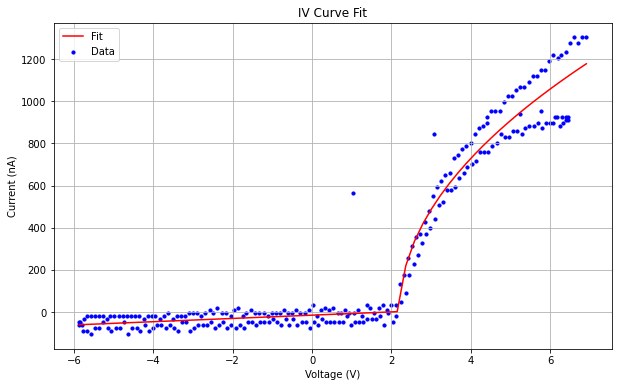

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(voltage, current, label="Data", color="blue", s=10)
plt.plot(Vfit, Ifit, label="Fit", color="red")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (nA)")
plt.title("IV Curve Fit")
plt.legend()
plt.grid()
plt.show()

In [33]:
print(popt)

[ 2.19806541e+00  1.83629064e+00  7.74968167e+00  7.95738487e+09
  1.09440923e+01 -2.19900707e+00]
